# Reverse MNIST

## Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import Layer
import importlib
import time
from copy import deepcopy
from IPython.display import display
from ipywidgets import FloatProgress

import mnist_loader
importlib.reload(mnist_loader)
importlib.reload(NN)
importlib.reload(Layer);

ImportError: No module named 'torch'

## Load MNIST DATA

In [1385]:
train, validate, test = mnist_loader.load_data_wrapper()
train = [torch.tensor(train[0]).float().to(device), torch.tensor(train[1]).float().to(device)]

In [1440]:
howmany = 1000 #1000 #50
train, validate, test = mnist_loader.load_data_wrapper()
train = [torch.tensor(train[0][:howmany]).float().to(device), torch.tensor(train[1][:howmany]).float().to(device)]

## Create Network

In [465]:
# Shallow Reversed
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=10))  # 0 Class vector
net.AddLayer(Layer.TopPELayer(n=784))  # 1 Input
net.Connect(0,1)
# Input layer is one-hot
net.layers[0].SetActivationFunction('softmax')
# Top vector reconstructed image, [0, 1]
net.layers[-1].SetActivationFunction('logistic')

net.SetTau(0.04)

In [1407]:
# Deep Reversed
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=10))  # 0 Target Class vector
net.AddLayer(Layer.PELayer(n=100))  # 1 Hidden
net.AddLayer(Layer.PELayer(n=200))  # 2 Hidden
net.AddLayer(Layer.TopPELayer(n=784))  # 3 Image
net.Connect(0,1)
net.Connect(1,2)
net.Connect(2,3)
# Input layer is one-hot
net.layers[1].SetActivationFunction('logistic')
net.layers[2].SetActivationFunction('logistic')
# Top vector reconstructed image, [0, 1]
net.layers[-1].SetActivationFunction('logistic')

net.SetTau(0.08)
net.learning_tau = 2.

In [1408]:
# Deep Reversed
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=10))  # 0 Target Class vector
net.AddLayer(Layer.PELayer(n=600))  # 1 Hidden
net.AddLayer(Layer.PELayer(n=600))  # 2 Hidden
net.AddLayer(Layer.TopPELayer(n=784))  # 3 Image
net.Connect(0,1)
net.Connect(1,2)
net.Connect(2,3)
# Input layer is one-hot
net.layers[1].SetActivationFunction('logistic')
net.layers[2].SetActivationFunction('logistic')
net.layers[3].SetActivationFunction('logistic')
# Top vector reconstructed image, [0, 1]
net.layers[-1].SetActivationFunction('logistic')

net.SetTau(0.08)
net.learning_tau = 2.

In [1459]:
net = NN.NeuralNetwork()
net.Load('MNIST reversed deep v4.npy')

In [1409]:
net.learning_blackout = 0.5

In [1312]:
net.layers[0].Probe(True)
net.layers[1].Probe(True)

## Train the Network

In [1445]:
start_time = time.time()
net.learning_blackout = 0.5
net.learning_tau = 5.
net.Learn(train[1], train[0], T=1.5, dt=0.005, epochs=1, batch_size=5)
end_time = time.time()
print('Total time: '+str(end_time-start_time))

Allocating
Total time: 134.75252294540405


In [1460]:
net.BackprojectExpectation(train[0])
z = net.layers[1].sigma(net.layers[1].v)@net.connections[0].M + net.layers[0].b
y_true = train[1]
y = np.array([np.array(Layer.softmax(k)) for k in z])

yarray = np.array(deepcopy(y))
yy = np.zeros(np.shape(yarray))
for idx, blah in enumerate(yarray):
    yy[idx,:] = NN.OneHot(blah)

err = np.sum(np.abs(yy-np.array(train[1])))/2.
print(err)
print('Accuracy = '+str((len(yy)-err)/len(yy)*100.)+'%')

Allocating
59.0
Accuracy = 94.1%


In [1461]:
net.BackprojectExpectation(test[0])
z = net.layers[1].sigma(net.layers[1].v)@net.connections[0].M + net.layers[0].b
y_true = test[1]
y = np.array([np.array(Layer.softmax(k)) for k in z])

yarray = np.array(deepcopy(y))
yy = np.zeros(np.shape(yarray))
for idx, blah in enumerate(yarray):
    yy[idx,:] = NN.OneHot(blah)

err = np.sum(np.abs(yy-np.array(test[1])))/2.
print(err)
print('Accuracy = '+str((len(yy)-err)/len(yy)*100.)+'%')

Allocating
2474.0
Accuracy = 75.26%


In [1376]:
net.layers[1].Probe(True)
net.layers[2].Probe(True)

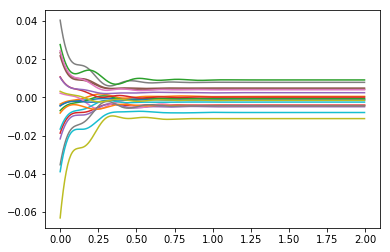

In [1384]:
p=269
net.Reset()
net.SetTau(0.08)
net.BackprojectExpectation(train[0][p])
net.PropagateErrors(train[1][p])
#net.ResetErrors()
net.Infer(2., train[1][p], train[0][p], dt=0.005, learning=False)

plt.plot(net.t_history, np.array(net.layers[1].e_history)[:,:20]);

In [1327]:
net.Reset()
net.BackprojectExpectation(train[0][p])
net.PropagateErrors(train[1][p])
net.layers[0].v

tensor([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')

In [1328]:
print(train[1][p])
net.layers[1].sigma(net.layers[1].v)@net.connections[0].M + net.layers[0].b

tensor([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')


tensor([ 0.0161,  1.0702,  0.1485, -0.1196, -0.0583,  0.0931,  0.0070,
         0.0567, -0.0953,  0.0035], device='cuda:0')

In [1303]:
net.layers[0].e

tensor(1.00000e-02 *
       [ 0.4752,  1.3066,  0.3663, -0.1307, -0.2637,  0.1197, -0.3695,
         0.2771, -0.1701,  0.3206], device='cuda:0')

Allocating
tensor([ 0.0015,  0.0713, -0.3050,  0.0850,  0.1950,  1.1789, -0.0114,
        -0.0876, -0.0459, -0.0619], device='cuda:0')


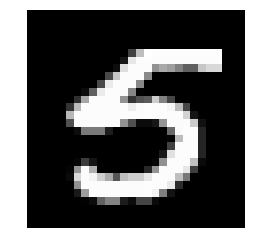

In [1448]:
p = 719 #147 or 35   for 2s
#p = 1 #133 or 141   for 7s
plt.imshow(np.reshape(train[0][p],[28,28]), cmap='gray'); plt.axis('off');
net.BackprojectExpectation(train[0][p])
#net.Reset()
zFF = net.layers[1].sigma(net.layers[1].v)@net.connections[0].M + net.layers[0].b
#z = net.Generate(10., train[0][p])
#print(z)
print(zFF)

In [1003]:
torch.mean(net.connections[0].M)

tensor(1.00000e-03 *
       -1.2365, device='cuda:0')

In [1005]:
[torch.mean(l.b) for l in net.layers]

[tensor(1.00000e-03 *
        8.0076, device='cuda:0'), tensor(1.00000e-03 *
        -8.5817, device='cuda:0'), tensor(1.00000e-03 *
        -1.1793, device='cuda:0'), tensor(0., device='cuda:0')]

In [1007]:
[torch.mean(l.e) for l in net.layers]

[tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0')]

In [948]:
# Train in reverse direction: one-hot -> reconstructed image
epochs = 5
T = 2.
dt = 0.01
start_time = time.time()
batch_size = 10
net.learning_tau = 30. #torch.tensor(batch_size).float().to(device) * 10.
fp = FloatProgress(min=0,max=epochs*len(train[0]))  
display(fp)
for k in range(epochs):
    batches = NN.MakeBatches(train[0], train[1], batch_size=batch_size)
    for x in batches:
        #net.Reset()
        net.BackprojectExpectation(x[0])
        net.Infer(T, x[1], x[0], dt=dt, learning=True)
        fp.value += batch_size
end_time = time.time()
print('Total time: '+str(end_time-start_time))

Allocating
Total time: 103.47046732902527


## Probe the Model

In [1449]:
z = net.Predict(10., train[1][0], dt=0.01)

## Save the Model

In [1457]:
net.Save('MNIST reversed deep v4.npy')

## Load the Model

In [1282]:
net = NN.NeuralNetwork()
net.Load('MNIST reversed deep v2.npy')

## Test the Network

tensor([-0.1991, -0.1662,  0.1106,  0.2979, -0.1943,  0.5603, -0.0035,
         0.2211, -0.5123,  0.6981], device='cuda:0')


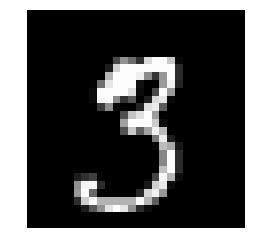

In [1358]:
p = 25 #147 or 35   for 2s
p = 9289 #133 or 141   for 7s
plt.imshow(np.reshape(train[0][p],[28,28]), cmap='gray'); plt.axis('off');
net.BackprojectExpectation(train[0][p])
#net.Reset()
zFF = net.layers[1].sigma(net.layers[1].v)@net.connections[0].M + net.layers[0].b
#z = net.Generate(10., train[0][p])
print(zFF)
#print(z)

In [574]:
net.Infer(4., test[1][p], test[0][p], dt=0.1, learning=True)
net.learn

True

In [801]:
net.layers[0].b

tensor([-0.0499,  0.0558,  0.0397,  0.1287,  0.0520, -0.0407,  0.0415,
        -0.0640,  0.0218,  0.0696], device='cuda:0')

In [802]:
net.SetTau(0.08)
net.layers[1].Probe(True)
net.layers[2].Probe(True)
#net.BackprojectExpectation(test[0][0])
#net.Reset()
net.Generate(4., test[0][0])
print(net.layers[0].v)
print(net.layers[1].v[:8])

Allocating
tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')
tensor([ 0.3598,  1.9552, -1.3044,  0.0423, -0.4499,  2.0527, -0.8055,
         1.0942], device='cuda:0')


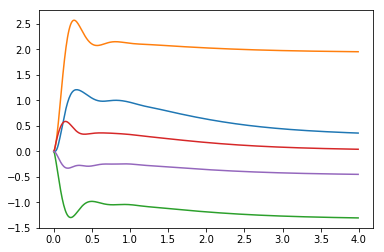

In [803]:
plt.plot(net.t_history, np.array(net.layers[1].v_history)[:,:5]);

In [804]:
net.Generate(4., test[0][1])
#net.BackprojectExpectation(test[0][1])
print(net.layers[0].v)
print(net.layers[1].v[:8])

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')
tensor([ 0.8965,  2.0493, -1.0175,  0.3032, -0.1225,  1.9652, -1.0904,
         0.3211], device='cuda:0')


tensor([ 0.0336,  0.2226,  0.1024,  0.1838, -0.0186,  0.0559,  0.1848,
        -0.0162,  0.1074,  0.1753], device='cuda:0')


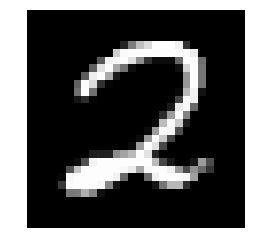

In [805]:
p = 35 #147 or 35   for 2s
#p = 133 #133 or 141   for 7s
plt.imshow(np.reshape(test[0][p],[28,28]), cmap='gray'); plt.axis('off');
net.BackprojectExpectation(test[0][p])
#net.Reset()
z = net.Generate(4., test[0][p])
print(z)

tensor([-0.0715, -0.1935,  0.1338,  0.0090, -0.1305,  0.2234,  0.2380,
        -0.1974, -0.0697,  1.0499], device='cuda:0')


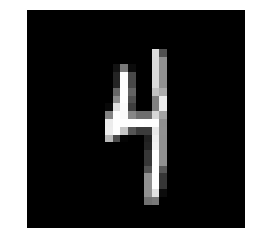

In [891]:
p = 65 #147 or 35   for 2s
#p = 141 #133 or 141   for 7s
plt.imshow(np.reshape(test[0][p],[28,28]), cmap='gray'); plt.axis('off');
#net.BackprojectExpectation(test[0][p])
net.Reset()
net.SetTau(0.08)
z = net.Generate(4., test[0][p])
print(z)

### Reconstructing a Digit

In [1488]:
p = 93
net.BackprojectExpectation(train[0][p])

In [1486]:
net.layers[2].SetBidirectional()

In [1491]:
print(net.layers[-2].v[:5])

tensor([-0.0058, -0.0839,  0.1388,  0.0028, -0.0806], device='cuda:0')


In [1493]:
print(net.layers[-2].v[:5])

tensor([-0.0058, -0.0839,  0.1388,  0.0028, -0.0806], device='cuda:0')


In [1499]:
net.connections[2].W[:5,:5] - net.connections[2].M[:5,:5].transpose(1,0)

tensor([[ 0.0224,  0.0469, -0.0638, -0.0436, -0.0764],
        [ 0.0288,  0.0149, -0.0668, -0.0461,  0.0497],
        [ 0.0469,  0.0303,  0.0353, -0.0546, -0.0866],
        [-0.0620,  0.0389, -0.0215,  0.0320,  0.0339],
        [-0.0111,  0.0284, -0.1791,  0.0470, -0.1173]], device='cuda:0')

In [1498]:
net.connections[2].M[:5,:5]

tensor([[-0.0418,  0.0073,  0.0133,  0.0263, -0.0428],
        [-0.0249, -0.1036,  0.0013, -0.0269, -0.0046],
        [ 0.0373,  0.0518, -0.0120,  0.0059,  0.1238],
        [ 0.0111,  0.0149,  0.0437, -0.0689, -0.0074],
        [ 0.0261, -0.0210,  0.0564, -0.0205,  0.0485]], device='cuda:0')

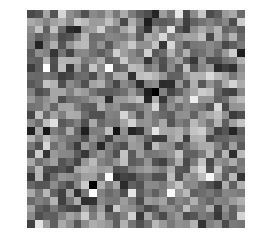

In [1492]:
#net.Reset()
#net.layers[1].v = torch.tensor(vmem)
net.layers[2].SetFixed()
net.layers[-1].v.zero_()
z = net.layers[-1].sigma(net.Predict(1., test[1][3]))
plt.imshow(np.reshape(z,[28, 28]), cmap='gray'); plt.axis('off');

In [1478]:
net.layers[2].beta

tensor(1., device='cuda:0')

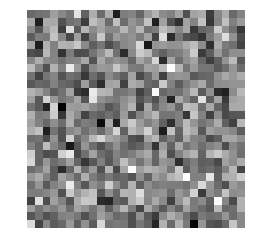

In [1453]:
#net.Reset()
z = net.layers[-1].e
plt.imshow(np.reshape(z,[28, 28]), cmap='gray'); plt.axis('off');

In [747]:
net.connections[-1].W

tensor([[-7.8700e+00, -7.5592e+00, -7.9245e+00,  ..., -7.8728e+00,
         -7.8759e+00, -7.5584e+00],
        [-7.6409e+01, -7.6099e+01, -7.6255e+01,  ..., -7.6007e+01,
         -7.6306e+01, -7.6060e+01],
        [-3.6636e+01, -3.6518e+01, -3.6407e+01,  ..., -3.6282e+01,
         -3.6350e+01, -3.6430e+01],
        ...,
        [-5.9620e+01, -5.9497e+01, -5.9523e+01,  ..., -5.9550e+01,
         -5.9734e+01, -5.9477e+01],
        [ 5.7501e+01,  5.7906e+01,  5.8006e+01,  ...,  5.8055e+01,
          5.7666e+01,  5.7868e+01],
        [ 1.8698e+01,  1.8819e+01,  1.8858e+01,  ...,  1.8783e+01,
          1.8691e+01,  1.8908e+01]], device='cuda:0')